<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Generative adversarial networks


В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

from torchinfo import summary
from IPython.display import clear_output

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения

In [2]:
# transform images once

# from PIL import Image
# import os
# from tqdm.notebook import tqdm

# PATH_OLD = '../data/faces_dataset_small/faces/'
# PATH_NEW = '../data/faces_dataset_small_jpg/faces/'
# SIZE = 64

# # size x size jpg
# for filename in tqdm(os.listdir(PATH)):
#     filename_w_e = os.path.splitext(filename)[0]
#     image = Image.open(os.path.join(PATH_OLD, filename))
#     resized_image_jpg = image.resize((SIZE, SIZE)).convert('RGB')
#     resized_image_jpg.save(os.path.join(PATH_NEW, filename_w_e + '.jpg'))

In [3]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    transform = tt.Compose([
#         tt.Resize(image_size),
#         tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize(*stats)
    ])
    
    ds = ImageFolder(root='../data/faces_dataset_small_png/', transform=transform)
    
    dl = DataLoader(ds, batch_size=batch_size, pin_memory=True)
    
    return dl

In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

faces_dataloader = get_dataloader(image_size, batch_size)

In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

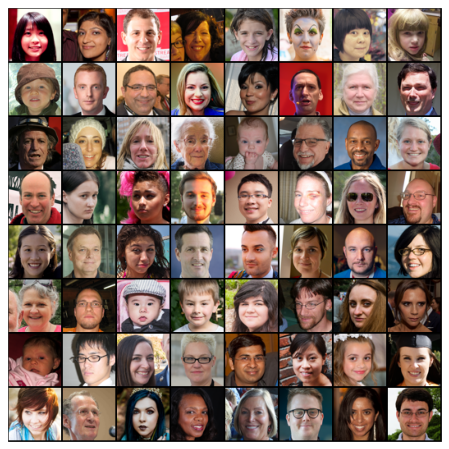

In [6]:
show_batch(faces_dataloader)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [7]:
discriminator = nn.Sequential(
    # in: 3 x 512 x 512

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4
    
#     nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 16 x 16
    
#     nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
    # out: 2048 x 8 x 8
    
#     nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
    # out: 4096 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [9]:
summary(discriminator, (1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [1, 64, 32, 32]           3,072
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─LeakyReLU: 1-3                         [1, 64, 32, 32]           --
├─Conv2d: 1-4                            [1, 128, 16, 16]          131,072
├─BatchNorm2d: 1-5                       [1, 128, 16, 16]          256
├─LeakyReLU: 1-6                         [1, 128, 16, 16]          --
├─Conv2d: 1-7                            [1, 256, 8, 8]            524,288
├─BatchNorm2d: 1-8                       [1, 256, 8, 8]            512
├─LeakyReLU: 1-9                         [1, 256, 8, 8]            --
├─Conv2d: 1-10                           [1, 512, 4, 4]            2,097,152
├─BatchNorm2d: 1-11                      [1, 512, 4, 4]            1,024
├─LeakyReLU: 1-12                        [1, 512, 4, 4]    

In [10]:
latent_size = 128 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

#     nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
    # out: 4096 x 4 x 4

#     nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
    # out: 2048 x 8 x 8

#     nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
    # out: 1024 x 16 x 16

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [11]:
summary(generator, (1, 128, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─ConvTranspose2d: 1-1                   [1, 512, 4, 4]            1,048,576
├─BatchNorm2d: 1-2                       [1, 512, 4, 4]            1,024
├─ReLU: 1-3                              [1, 512, 4, 4]            --
├─ConvTranspose2d: 1-4                   [1, 256, 8, 8]            2,097,152
├─BatchNorm2d: 1-5                       [1, 256, 8, 8]            512
├─ReLU: 1-6                              [1, 256, 8, 8]            --
├─ConvTranspose2d: 1-7                   [1, 128, 16, 16]          524,288
├─BatchNorm2d: 1-8                       [1, 128, 16, 16]          256
├─ReLU: 1-9                              [1, 128, 16, 16]          --
├─ConvTranspose2d: 1-10                  [1, 64, 32, 32]           131,072
├─BatchNorm2d: 1-11                      [1, 64, 32, 32]           128
├─ReLU: 1-12                             [1, 64, 32, 32

torch.Size([128, 3, 64, 64])


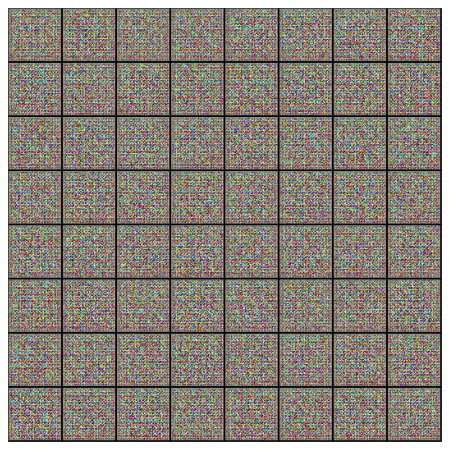

In [12]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb.cuda())
print(fake_images.shape)
show_images(fake_images.cpu())

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [13]:
def fit(model, criterion, epochs, lr):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(faces_dataloader):
            real_images = real_images.cuda()
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=torch.device('cuda'))
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=torch.device('cuda'))
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=torch.device('cuda'))
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=torch.device('cuda'))
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=torch.device('cuda'))
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
            
        # visualize        
        clear_output(wait=True)
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        
        xb = torch.randn(batch_size, latent_size, 1, 1) 
        fake_images = model['generator'](xb.cuda())
        show_images(fake_images.cpu())
        
        plt.figure(figsize=(15, 6))
        plt.plot(losses_d, '-')
        plt.plot(losses_g, '-')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['Discriminator', 'Generator'])
        plt.title('Losses')
        
        plt.figure(figsize=(15, 6))
        plt.plot(real_scores, '-')
        plt.plot(fake_scores, '-')
        plt.xlabel('epoch')
        plt.ylabel('score')
        plt.legend(['Real', 'Fake'])
        plt.title('Scores');
        plt.show()
        
        # Save generated images
#         if epoch == epochs - 1:
#             save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [14]:
lr = 0.0001

discriminator = discriminator.cuda()
generator = generator.cuda()
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

Epoch [100/100], loss_g: 3.9266, loss_d: 0.1685, real_score: 0.9229, fake_score: 0.0748


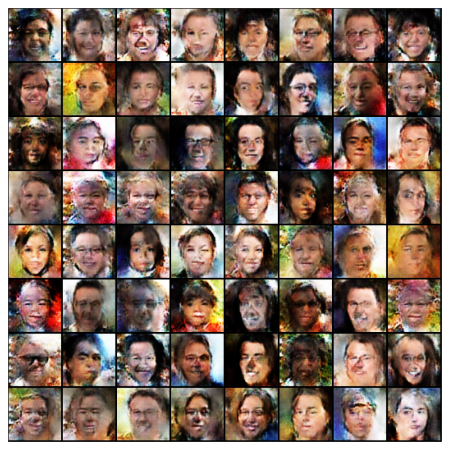

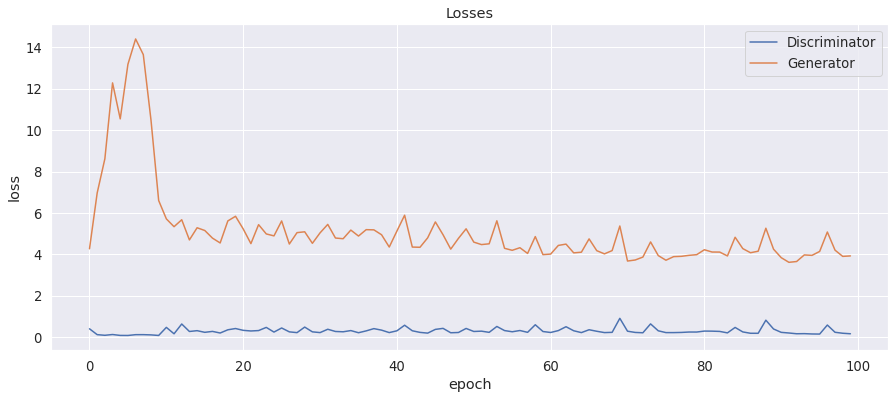

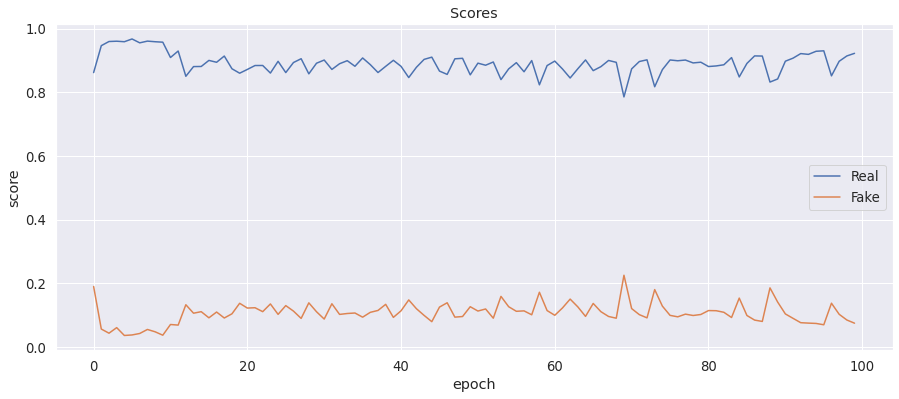

In [15]:
epochs = 100
history = fit(model, criterion, epochs, lr)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [16]:
n_images = 64

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=torch.device('cuda'))
fake_images = model["generator"](fixed_latent)

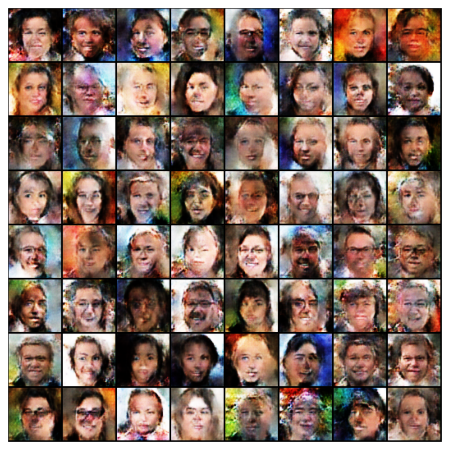

In [17]:
# 100 epochs 64x64 png
show_images(fake_images.cpu())

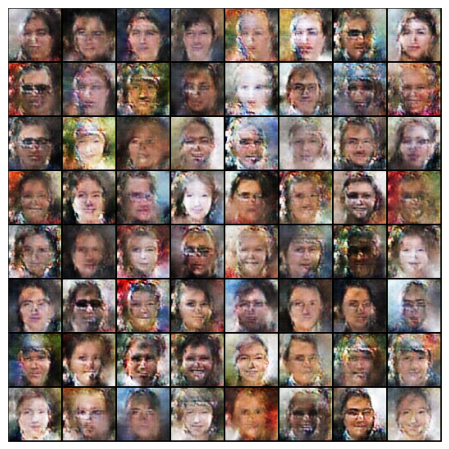

In [30]:
# 100 epochs 64x64 jpg
show_images(fake_images.cpu())

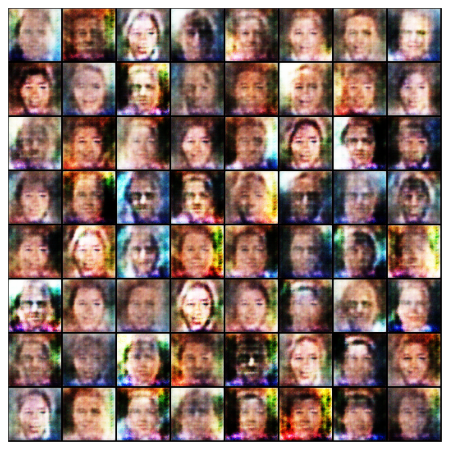

In [25]:
# 40 epochs 512x512 png
show_images(fake_images.cpu())

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
n_images = len(faces_dataloader.dataset.imgs)

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=torch.device('cuda'))
fake_images = model["generator"](fixed_latent)

In [29]:
fake_images.shape

torch.Size([3143, 3, 64, 64])

In [32]:
faces_dataloader.dataset.

[('../data/faces_dataset_small_png/faces/00055.png', 0),
 ('../data/faces_dataset_small_png/faces/00237.png', 0),
 ('../data/faces_dataset_small_png/faces/00240.png', 0),
 ('../data/faces_dataset_small_png/faces/00241.png', 0),
 ('../data/faces_dataset_small_png/faces/00242.png', 0),
 ('../data/faces_dataset_small_png/faces/00243.png', 0),
 ('../data/faces_dataset_small_png/faces/00244.png', 0),
 ('../data/faces_dataset_small_png/faces/00245.png', 0),
 ('../data/faces_dataset_small_png/faces/00246.png', 0),
 ('../data/faces_dataset_small_png/faces/00247.png', 0),
 ('../data/faces_dataset_small_png/faces/00248.png', 0),
 ('../data/faces_dataset_small_png/faces/00249.png', 0),
 ('../data/faces_dataset_small_png/faces/00253.png', 0),
 ('../data/faces_dataset_small_png/faces/00255.png', 0),
 ('../data/faces_dataset_small_png/faces/00257.png', 0),
 ('../data/faces_dataset_small_png/faces/00258.png', 0),
 ('../data/faces_dataset_small_png/faces/00259.png', 0),
 ('../data/faces_dataset_small_

In [19]:
knn = KNeighborsClassifier(n_neighbors=1)

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: